In [424]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math, statistics
import scipy.sparse.linalg as sla
DEBUG = "CIRCLES"

In [425]:
class Ball:
    def __init__(self, team, label, loc):
        self.team = team
        self.label = label
        self.loc = loc

# Homography 

In [426]:
def compute_homography(src_pts, dest_pts):
    np_src = np.array(src_pts)
    np_dest = np.array(dest_pts)
    # construct A
    A = np.zeros((len(src_pts[:]) * 2, 9))
    A[0::2, 2] = 1
    A[1::2, 5] = 1
    A[0::2, 0:2] = np_src
    A[1::2, 3:5] = np_src
    A[0::2, 6] = - np_dest[:, 0] * np_src[:, 0]
    A[1::2 ,6] = - np_dest[:, 1] * np_src[:, 0]
    A[0::2, 7] = - np_dest[:, 0] * np_src[:, 1]
    A[1::2, 7] = - np_dest[:, 1] * np_src[:, 1]
    A[0::2, 8] = - np_dest[:, 0]
    A[1::2, 8] = - np_dest[:, 1]
    w,v = sla.eigs(A.T @ A, 1, which="SR")
    return np.reshape(v, (3, 3))


def apply_homography(H, src_pts):
    np_src = np.array(src_pts)
    dest_pts = np.zeros(np_src.shape)
    for i in range(len(np_src)):
        pt = np_src[i, :]
        vec = np.zeros((3, ))
        vec[0:2] = pt.T
        vec[2] = 1
        d = H @ vec
        dest_pts[i, :] = d[0:2] / d[2]
    return dest_pts


[[5. 1.]
 [4. 2.]
 [3. 3.]
 [2. 4.]]


/var/folders/hp/htr3k2bx6j930_7rq9px4zbr0000gn/T/ipykernel_53061/145400110.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  dest_pts[i, :] = d[0:2] / d[2]


## Threshold by color and mask

In [427]:
# order is blue, green, red
def mask_table(color_img):
    pixels = []
    for i in color_img:
        for j in i:
            pixels.append(j)
    pixels = np.array(pixels)
    bins = [0,100,150,255]
    hist, bins = np.histogramdd(pixels, bins=(bins, bins, bins))

    # find the highest histogram bin
    max_r, max_g, max_b, max_val = 0, 0, 0, 0
    for r in range(hist.shape[0]):
        for g in range(hist.shape[1]):
            for b in range(hist.shape[2]):
                if hist[r][g][b] > max_val:
                    max_val = hist[r][g][b]
                    (max_r, max_g, max_b) = r, g, b
    bins = bins[0]
    lower = np.array([bins[max_r], bins[max_g], bins[max_b]])
    upper = np.array([bins[max_r + 1], bins[max_g + 1], bins[max_b + 1]])
    # just get the pixels in the highest histogram bin
    mask = cv2.inRange(color_img, lower, upper)
    print(lower)
    print(upper)
    # plt.imshow(mask)
    # plt.title('mask before dilation')
    # plt.show()
    # fill in the holes
    kernel = np.ones((7, 7),np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=10)
    # dilation is grayscale, lets convert it to have three channels
    rgb_dilation = np.uint8(np.zeros((dilation.shape[0], dilation.shape[1], 3)))
    for i in range(rgb_dilation.shape[0]):
        for j in range(rgb_dilation.shape[1]):
            rgb_dilation[i][j][:] = dilation[i][j]

    res = cv2.bitwise_and(color_img, rgb_dilation)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    if DEBUG == "MASK" or DEBUG == "ALL":
        plt.imshow(res)
        plt.show()
    return res


# Get corners of table

In [428]:
def blur_img(img, iters):
    blurred = img.copy()
    kernelsize = (5,5)
    for i in range(iters):
        blurred = cv2.GaussianBlur(blurred, kernelsize, sigmaX=0, sigmaY=0) 
    return blurred

def find_clusters(circles, num_clusters, dist_threshold, img, bounds=[]):
    if len(bounds) != 0:
        bounds = np.array(bounds)
        min_x = min(bounds[:,0])
        min_y = min(bounds[:,1])
        max_x = max(bounds[:,0])
        max_y = max(bounds[:,1])
    clusters = []
    for i in circles[0,:]:
        in_bounds = False
        if len(bounds) == 0:
            in_bounds = True
        # this padding of 12 pixels is so that the side pockets don't get included
        elif len(bounds) > 0 and min_x + 12 <= i[0] <= max_x -12 and min_y + 12 <= i[1] <= max_y - 12:
            in_bounds = True
        if in_bounds:
            found_cluster = False
            for cluster in clusters:
                for circ in cluster:
                    if math.dist((circ[0], circ[1]), (i[0], i[1])) < dist_threshold:
                        cluster.append(i)
                        found_cluster = True
                    if found_cluster: break
                if found_cluster: break
            if not found_cluster:
                clusters.append([i])
    if len(clusters) < num_clusters:
        raise "not enough clusters found"
    
    # find the n biggest clusters, these are (hopefully) our corner pockets
    clusters.sort(reverse=True, key=len)
    cluster_centers = []
    out_img = img.copy()
    for cluster in clusters[0:num_clusters]:
        xes = []
        yes = []
        radii = []
        for i in cluster:
            xes.append(i[0])
            yes.append(i[1])
            radii.append(i[2])
            cv2.circle(out_img,(i[0],i[1]),i[2],(255,0,255),2) # draw the outer circle
            cv2.circle(out_img,(i[0],i[1]),2,(0,255,0),3) # draw the center of the circle
        cluster_centers.append((statistics.mean(xes), statistics.mean(yes), statistics.mean(radii)))
    plt.imshow(out_img)
    plt.show()
    cv2.imwrite("clusters.png", out_img)
    return cluster_centers

def get_corners(masked_img):
    msk_img = masked_img.copy()
    img_blur = blur_img(msk_img, 9)
    gray_blur = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY)
    h_circles = cv2.HoughCircles(gray_blur, cv2.HOUGH_GRADIENT, param1=120, param2=12, dp=1, minRadius=25, maxRadius=30, minDist=1)
    h_circles = np.uint16(np.around(h_circles))
    for i in h_circles[0,:]:
        cv2.circle(msk_img,(i[0],i[1]),i[2],(0,255,0),2) # draw the outer circle
        cv2.circle(msk_img,(i[0],i[1]),2,(0,0,255),3) # draw the center of the circle
    plt.imshow(msk_img)
    plt.title('hough circle transform')
    plt.show()
    
    # construct clusters of the hough circles
    cluster_centers = find_clusters(h_circles, 4, 15, msk_img)
    corners_img = masked_img.copy()
    for c in cluster_centers:
        cv2.circle(corners_img,(c[0],c[1]),4,(255,0,255),5)
    plt.imshow(corners_img)
    plt.title('the centroid of the cluster')
    plt.show()
    cv2.imwrite('table_corners.png', corners_img)
    return cluster_centers

## Hough Circles

In [429]:
def hough_circles(full_img, masked_image, bounds):
    cimg = full_img.copy()
    
    if len(masked_image.shape) > 2:
        gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = masked_image
    plt.imshow(gray)
    plt.title('circle input')
    plt.show()
    alt = False
    canny = cv2.Canny(gray, 50, 100)
    plt.imshow(canny)
    plt.title('canny')
    plt.show()
    if alt:
        h_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT, param1=300, param2=0.5, dp=1, minRadius=14, maxRadius=16, minDist=1)
    else:
        h_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, param1=80, param2=8, dp=1, minRadius=12, maxRadius=15, minDist=1)
    if h_circles is None:
        print("no circles found")
        return []
    h_circles = np.uint16(np.around(h_circles))

    k = 0
    for i in h_circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.putText(cimg, f'{k}', (i[0],i[1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1)
        k+=1

    if DEBUG == "CIRCLES" or DEBUG == "ALL":
        plt.title("Hough Circles")
        plt.imshow(cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))
        cv2.imwrite("circles.png", cimg)
    
    cluster_centers = find_clusters(h_circles, 16, 15, cimg, bounds=bounds)
    ball_centers_img = full_img.copy()
    for c in cluster_centers:
        cv2.circle(ball_centers_img,(c[0],c[1]),4,(255,0,255),5)
        cv2.circle(ball_centers_img, (c[0],c[1]),2*c[2],(0,255,0),1)
    plt.imshow(ball_centers_img)
    plt.title('the centroids of the cluster')
    plt.show()
    cv2.imwrite('ball_centers.png', ball_centers_img)
    return cluster_centers


## Assume we have correct circles

In [430]:
def label_balls(color_img, hough_circs):
    ## get the pixel values of all the circles
    balls = []
    num_solids = 0
    num_stripes = 0
    if len(hough_circs) == 0:
        return balls
    for circle in hough_circs:
        rad = circle[2]
        center_x = circle[1]
        center_y = circle[0]
        # iterate over the box containing the circle, and extend it a bit since our circles arent perfect
        pixels = []
        for i in range(4*rad):
            for j in range(4*rad):
                tmp_x = round(center_x - 2*rad + i)
                tmp_y = round(center_y - 2*rad + j)
                # check that the point is actually in the circle
                if np.power(tmp_x - center_x, 2) + np.power(tmp_y - center_y, 2) < np.power(rad, 2):
                    pix = color_img[tmp_x][tmp_y]
                    pixels.append(pix)
        pixels = np.array(pixels)
        hist, bins = np.histogramdd(pixels, bins=(3, 3, 3), density=False)
        if hist[0,0,0] > 375: # eight ball
            balls.append(Ball(team=None, label="eight", loc=(center_y, center_x)))
        elif hist[2,2,2] > 300: # cue ball
            balls.append(Ball(team=None, label="cue", loc=(center_y, center_x)))
        elif hist[0,0,0] > 310 or np.sum(hist[1]) > 300: # solids
            balls.append(Ball(team="solids", label=str(num_solids), loc=(center_y, center_x)))
            num_solids += 1
        elif hist[2,2,2] > 10: # stripes
            balls.append(Ball(team="stripes", label=str(num_stripes), loc=(center_y, center_x)))
            num_stripes += 1
        elif np.sum(hist) - hist[0,0,0] - hist[2,2,2] > 200:
            balls.append(Ball(team="solids", label=str(num_solids), loc=(center_y, center_x)))
            num_solids += 1
        else:
            balls.append(Ball(team=None, label="unlabeled", loc=(center_y, center_x)))

    labeled_balls = color_img.copy()
    for b in balls:
        if b.team == 'solids': col = (0,255,0)
        if b.team == 'stripes': col = (255,0,255)
        if b.team is None: col = (255, 150, 0)
        cv2.putText(labeled_balls, b.team if b.team else b.label, (b.loc[0],b.loc[1]), cv2.FONT_HERSHEY_PLAIN, 2, col, 2)
        cv2.circle(labeled_balls,(b.loc[0],b.loc[1]),3,col,3)

    if DEBUG == "LABELS" or DEBUG == "ALL":
        plt.imshow(cv2.cvtColor(labeled_balls, cv2.COLOR_BGR2RGB))
    cv2.imwrite("labels.png", labeled_balls)
    return balls


In [431]:
def scharr(img):
    scharr_X = cv2.Scharr(img, cv2.CV_64F, 1, 0) 
    scharr_X_abs = np.uint8(np.absolute(scharr_X)) 
    scharr_Y = cv2.Scharr(img, cv2.CV_64F, 0, 1) 
    scharr_Y_abs = np.uint8(np.absolute(scharr_Y)) 
    scharr_XY_combined = cv2.bitwise_or(scharr_Y_abs,scharr_X_abs) 
    return scharr_XY_combined

[  0   0 150]
[100 100 255]


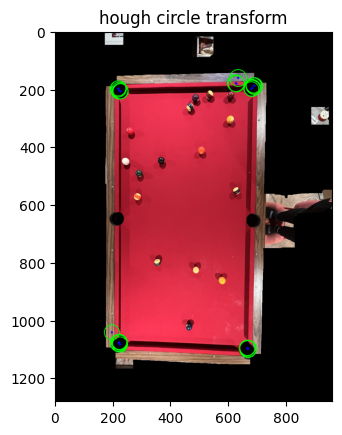

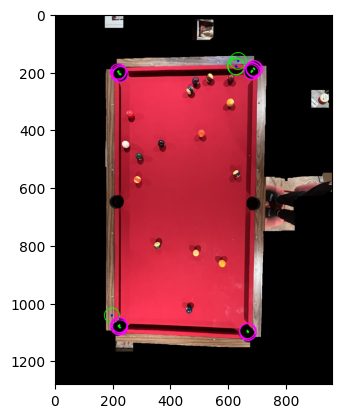

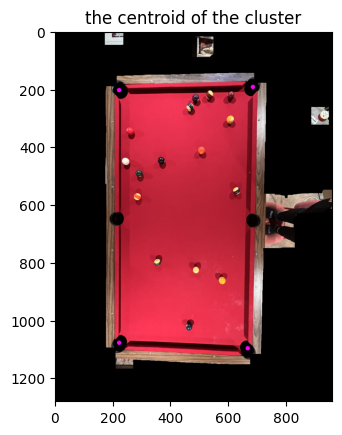

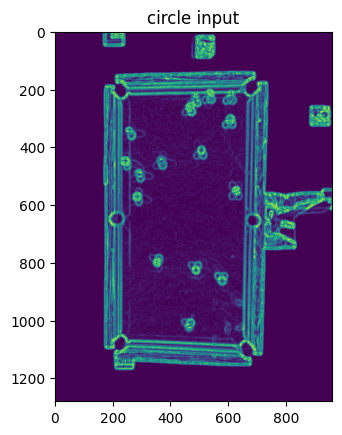

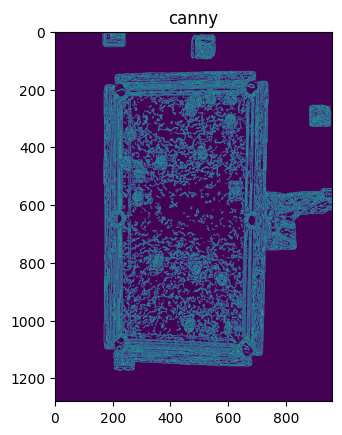

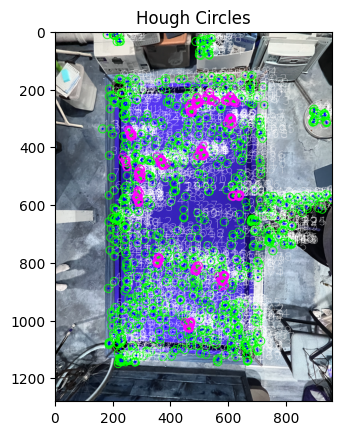

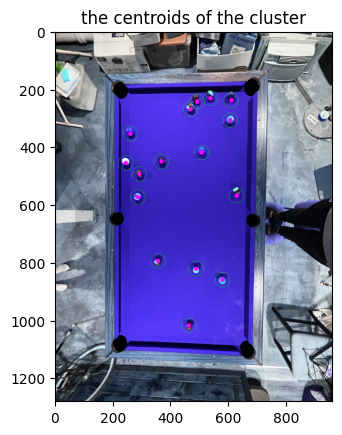

In [432]:


image_path = "./new_images/1280x1280/IMG_2737.png"
color = cv2.imread(image_path,1)
masked_img = mask_table(color)
corners = get_corners(masked_img=masked_img)
blurred_img = blur_img(masked_img, iters=9)
sch = scharr(blurred_img)


circles = hough_circles(color, sch, bounds=corners)
balls = label_balls(color, circles)


## Assume we have correct circles

In [1152]:
def label_balls(color_img, hough_circs):
    ## get the pixel values of all the circles
    balls = []
    num_solids = 0
    num_stripes = 0
    if len(hough_circs) == 0:
        return balls
    for circle in hough_circs:
        rad = circle[2]
        center_x = circle[1]
        center_y = circle[0]
        # iterate over the box containing the circle
        num_colored = 0
        num_white = 0
        num_black = 0
        num_felt = 0
        for i in range(3*rad):
            for j in range(3*rad):
                tmp_x = round(center_x - 1.5*rad + i)
                tmp_y = round(center_y - 1.5*rad + j)
                # check that the point is actually in the circle
                if np.power(tmp_x - center_x, 2) + np.power(tmp_y - center_y, 2) < np.power(rad, 2):
                    pix = color_img[tmp_x][tmp_y]
                    white_thresh = 120
                    black_thresh = 40
                    # the white pixels
                    if pix[0] > white_thresh and pix[1] > white_thresh and pix[2] > white_thresh:
                        num_white += 1
                    # the black pixels
                    elif pix[0] < black_thresh and pix[1] < black_thresh and pix[2] < black_thresh:
                        num_black += 1
                    elif pix[0] < 100 and pix[1] < 100 and pix[2] > 150:
                        num_felt += 1
                    else:
                        num_colored += 1
        total_pixels = num_white + num_colored + num_black + num_felt

        # print(num_white / total_pixels)
        if total_pixels == 0:
            continue
        if num_white / total_pixels >= 0.65:
            ball = Ball(team=None, label="cue", loc=(center_y, center_x))
        elif num_black / total_pixels >= 0.3:
            ball = Ball(team=None, label="eight", loc=(center_y, center_x))
        elif num_white / (num_white + num_colored + num_black) >= 0.1:
            ball = Ball(team="stripes", label=str(num_stripes), loc=(center_y, center_x))
            num_stripes += 1
        else:
            ball = Ball(team="solids", label=str(num_solids), loc=(center_y, center_x))
            num_solids += 1
        balls.append(ball)

    labeled_balls = color_img.copy()
    for b, i in balls:
        if b.team == 'solids': col = (0,255,0)
        if b.team == 'stripes': col = (255,0,255)
        if b.team == None: col = (255,150,0)
        cv2.putText(labeled_balls, i if b.team else b.label, (b.loc[0],b.loc[1]), cv2.FONT_HERSHEY_PLAIN, 1, col, 1)
        cv2.circle(labeled_balls,(b.loc[0],b.loc[1]),2,col,2)

    if DEBUG == "LABELS" or DEBUG == "ALL":
        plt.imshow(cv2.cvtColor(labeled_balls, cv2.COLOR_BGR2RGB))
    cv2.imwrite("labels.png", labeled_balls)
    return balls


In [1153]:
def scharr(img):
    scharr_X = cv2.Scharr(img, cv2.CV_64F, 1, 0) 
    scharr_X_abs = np.uint8(np.absolute(scharr_X)) 
    scharr_Y = cv2.Scharr(img, cv2.CV_64F, 0, 1) 
    scharr_Y_abs = np.uint8(np.absolute(scharr_Y)) 
    scharr_XY_combined = cv2.bitwise_or(scharr_Y_abs,scharr_X_abs) 
    return scharr_XY_combined

[  0   0 150]
[100 100 255]


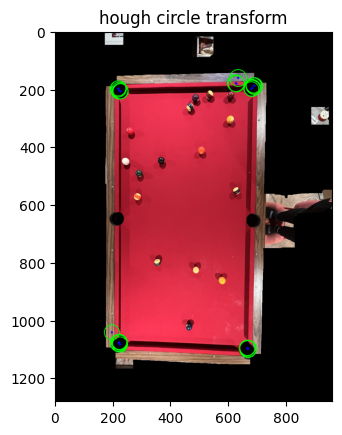

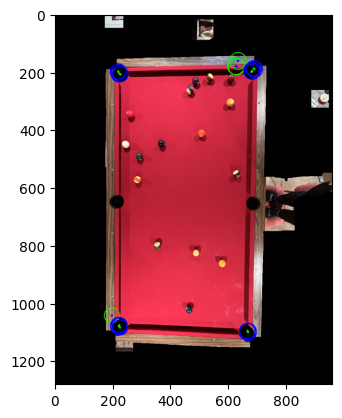

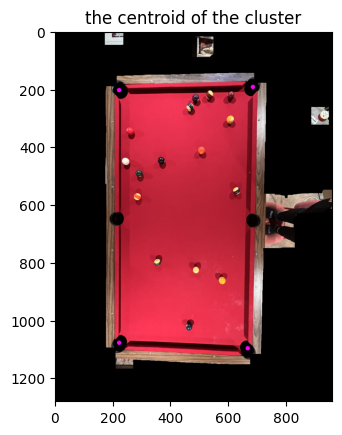

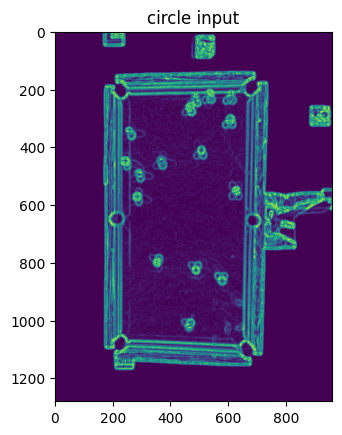

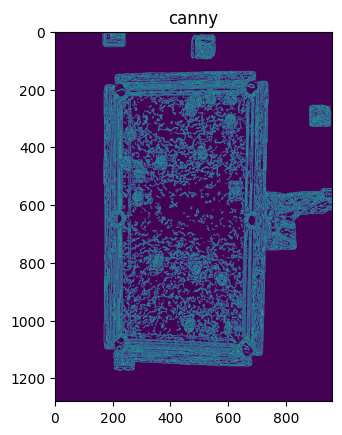

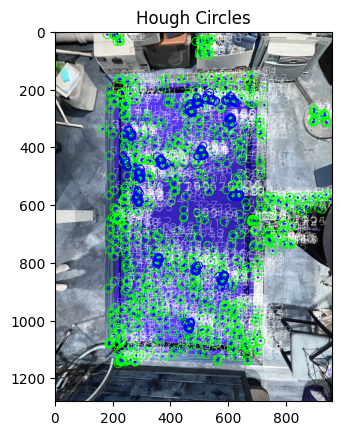

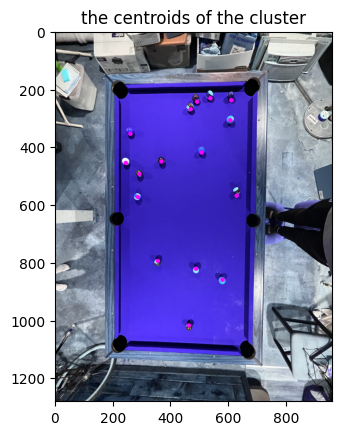

In [1154]:


image_path = "./new_images/1280x1280/IMG_2737.png"
color = cv2.imread(image_path,1)
masked_img = mask_table(color)
corners = get_corners(masked_img=masked_img)
blurred_img = blur_img(masked_img, iters=9)
sch = scharr(blurred_img)


circles = hough_circles(color, sch, bounds=corners)
balls = label_balls(color, circles)
